In [1]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PrepareData import read_json, make_folder

# EXP 1: Model-aware results

## Read results from disc

In [3]:
repo_dir = sys.path[0].replace('notebooks', '')
eval_path=repo_dir+ 'eval/'
# data_name = 'lsac'
# temp_df = pd.read_csv(eval_path+'res-{}.csv'.format(data_name))
# temp_df.head()

In [4]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        if x.iloc[0] in ['ERRDiff', 'FNRDiff', 'FPRDiff']: # measures with lower value means better
            if x.iloc[1] > 0: 
                return 0
            else: # G0 has better outcome
                return 1
        else: # for measures like eqdiff, avgoddsdiff with higher value means better
            if x.iloc[1] < 0: 
                return 0
            else: # G0 has better outcome
                return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [5]:
seeds = [1, 12345, 6, 2211, 15]
# seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]
# seeds = [88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]

models = ['LR', 'TR']

datasets = ['lsac', 'meps16', 'ACSE', 'ACSP', 'bank', 'credit', 'ACSH', 'ACSM', 'ACSI'] #'cardio', 'bank', 'credit', 'ACSH', 'ACSM', 'ACSI'

In [6]:
# eval_suffix = '-min_g0-0.5'
eval_suffix = 'res-aware'
# eval_suffix = 'res-min'
eval_file = 'scc_datasets{}_n{}{}.csv'.format(len(datasets), len(seeds), eval_suffix)
if os.path.exists(eval_path+eval_file):
    eval_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results at {}'.format(eval_path+eval_file))
else:
    eval_df = pd.DataFrame()
    for data_name in datasets:
        cur_eval_df = pd.read_csv(eval_path+'{}-{}.csv'.format(eval_suffix, data_name))
#         print(cur_eval_df.head())
        cur_eval_df['norm_value'] = cur_eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
        cur_eval_df['norm_flag'] = cur_eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

        eval_df = pd.concat([eval_df, cur_eval_df])
    
    eval_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))

Save evaluation results at /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/eval/scc_datasets9_n5res-aware.csv


In [7]:
eval_df.head()

,data,model,seed,method,group,metric,value,norm_value,norm_flag
0,lsac,LR,1,SCC-KAM-AWARE,all,AUC,0.621000,0.621000,0
1,lsac,LR,1,SCC-KAM-AWARE,all,ACC,0.740000,0.740000,0
2,lsac,LR,1,SCC-KAM-AWARE,all,SR,0.769336,0.769336,0
3,lsac,LR,1,SCC-KAM-AWARE,all,BalAcc,0.620753,0.620753,0
4,lsac,LR,1,SCC-KAM-AWARE,G0,AUC,0.500000,0.500000,0


In [8]:
# special fix: reading original results from evaluation of multi
orig_df = pd.read_csv(eval_path+'scc_mcc_datasets10_n5res.csv')
orig_df.head()

,data,model,seed,method,group,metric,value,norm_value,norm_flag
0,lsac,LR,1,MCC-MIN,all,AUC,0.670000,0.670000,0
1,lsac,LR,1,MCC-MIN,all,ACC,0.740000,0.740000,0
2,lsac,LR,1,MCC-MIN,all,SR,0.718682,0.718682,0
3,lsac,LR,1,MCC-MIN,all,BalAcc,0.670162,0.670162,0
4,lsac,LR,1,MCC-MIN,G0,AUC,0.627000,0.627000,0


In [9]:
cur_orig = orig_df[orig_df['data'].isin(datasets)]
eval_df = pd.concat([eval_df, cur_orig])

In [30]:
eval_df.query('data=="ACSP" and method=="SCC-KAM-AWARE" and model=="LR" and metric=="DI" and group=="all"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
13,ACSP,LR,1,SCC-KAM-AWARE,all,DI,1.051808,0.950743,1
53,ACSP,LR,12345,SCC-KAM-AWARE,all,DI,1.165703,0.857852,1
93,ACSP,LR,6,SCC-KAM-AWARE,all,DI,1.138009,0.878728,1
133,ACSP,LR,2211,SCC-KAM-AWARE,all,DI,1.041573,0.960087,1
173,ACSP,LR,15,SCC-KAM-AWARE,all,DI,1.044309,0.957571,1


In [31]:
eval_df.query('data=="ACSE" and method=="SCC-KAM-AWARE" and model=="LR" and metric=="DI" and group=="all"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
13,ACSE,LR,1,SCC-KAM-AWARE,all,DI,1.082007,0.924209,1
53,ACSE,LR,12345,SCC-KAM-AWARE,all,DI,1.100044,0.909054,1
93,ACSE,LR,6,SCC-KAM-AWARE,all,DI,1.169294,0.855217,1
133,ACSE,LR,2211,SCC-KAM-AWARE,all,DI,1.137077,0.879448,1
173,ACSE,LR,15,SCC-KAM-AWARE,all,DI,1.136056,0.880238,1


In [32]:
eval_df.query('data=="lsac" and method=="SCC-KAM-AWARE" and model=="LR" and metric=="DI" and group=="all"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
13,lsac,LR,1,SCC-KAM-AWARE,all,DI,1.332157,0.750662,1
53,lsac,LR,12345,SCC-KAM-AWARE,all,DI,1.400164,0.714202,1
93,lsac,LR,6,SCC-KAM-AWARE,all,DI,1.442177,0.693396,1
133,lsac,LR,2211,SCC-KAM-AWARE,all,DI,1.317583,0.758965,1
173,lsac,LR,15,SCC-KAM-AWARE,all,DI,1.388752,0.720071,1


In [20]:
eval_df.query('data=="ACSI" and method=="SCC-KAM-AWARE" and model=="LR" and metric=="DI" and group=="all"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
13,ACSI,LR,1,SCC-KAM-AWARE,all,DI,1.632462,0.612572,1
41,ACSI,LR,12345,SCC-KAM-AWARE,all,DI,1.168741,0.855622,1
69,ACSI,LR,6,SCC-KAM-AWARE,all,DI,1.200492,0.832992,1
97,ACSI,LR,2211,SCC-KAM-AWARE,all,DI,1.403303,0.712605,1
125,ACSI,LR,15,SCC-KAM-AWARE,all,DI,1.439078,0.694889,1


In [21]:
eval_df.query('data=="ACSI" and method=="ORIG" and model=="LR" and metric=="DI" and group=="all"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
16873,ACSI,LR,1,ORIG,all,DI,1.349378,0.741082,1
17053,ACSI,LR,12345,ORIG,all,DI,1.485703,0.673082,1
17233,ACSI,LR,6,ORIG,all,DI,1.303503,0.767164,1
17413,ACSI,LR,2211,ORIG,all,DI,1.514898,0.660110,1
17593,ACSI,LR,15,ORIG,all,DI,1.461562,0.684199,1


## Draw barplots

In [10]:
def bar_plots(df, output_name, vis_datasets, vis_metric, vis_settings, group_input=None,
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670'], bg_color = '#f3f3f3', x_tick_offset=6.3,
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=5, save_to_disc=True):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    line_styles = []
    x_bars = []
    ind = 0
    
    for off_i, name in enumerate(vis_datasets):
        vis_df = input_df[(input_df['data']==name) & (input_df['metric']==vis_metric) & (input_df['group']==group_input)].copy()
        for setting_i in vis_settings:
            set_df = vis_df[vis_df['method']==setting_i]
            
            if set_df.shape[0] > 0:
                y_values = np.array(set_df['norm_value'])
                n_reverse = sum(np.array(set_df['norm_flag']))
                if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
                    dash_filling.append(True)
                else:
                    dash_filling.append(False)
                
                cur_mean = np.mean(y_values)
                cur_std = np.std(y_values)
#                 if data_name == 'lsac' and setting_i == 'OMN-ONE':
#                     print(data_name, cur_mean, cur_std)
                if cur_mean == 0:
#                     print('++', name, setting_i, cur_mean)
                    cur_mean = 0.01 # for visualization purpose so that the bar exists in the plot
                    line_styles.append('solid')
                elif vis_metric == 'BalAcc' and cur_std < 0.01 and abs(cur_mean-0.5) < 0.1:
                    # dashed border
                    line_styles.append('dashed')
                elif vis_metric in ['DI', 'AvgOddsDiff', 'EQDiff'] and cur_std < 0.01 and abs(1-cur_mean) < 0.0001:
                    line_styles.append('dashed')
                    cur_mean = 0.001
                else:
                    line_styles.append('solid')
                    
                bar_mean.append(cur_mean)
                bar_std.append(cur_std)
            else: # no model is returned
                dash_filling.append(False)
                line_styles.append('dashed')
                bar_mean.append(0)
                bar_std.append(0)
                
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
    bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)
#     print('-->', vis_metric, bar_mean)
    
    n_bars = len(vis_settings)
    for idx, patch in enumerate(bplot):
        patch.set_facecolor(colors[idx % n_bars])
        
        if dash_filling[idx]:
            patch.set_hatch('//')
            patch.set_edgecolor("#cb4154")
        else:
            patch.set_edgecolor("black")
        patch.set_linestyle(line_styles[idx])
        
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_i, label=legend_i)

    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    plt.xlim([-1, max(x_bars)+1])
    plt.xticks([(x-1)*x_tick_offset+0.8 for x in range(1, len(vis_datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(output_name, bbox_inches="tight")
        print('Bar plot is saved at ', output_name)
        plt.close()

In [11]:
plot_path = repo_dir+ 'intermediate/plots/aware/'
# if 'sort_' in eval_suffix or 'min_' in eval_suffix:
#     plot_path = plot_path + 'err/'
#     make_folder(plot_path)
# else:
#     pass
# make_folder(plot_path)

In [12]:
plot_path

'/Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/aware/'

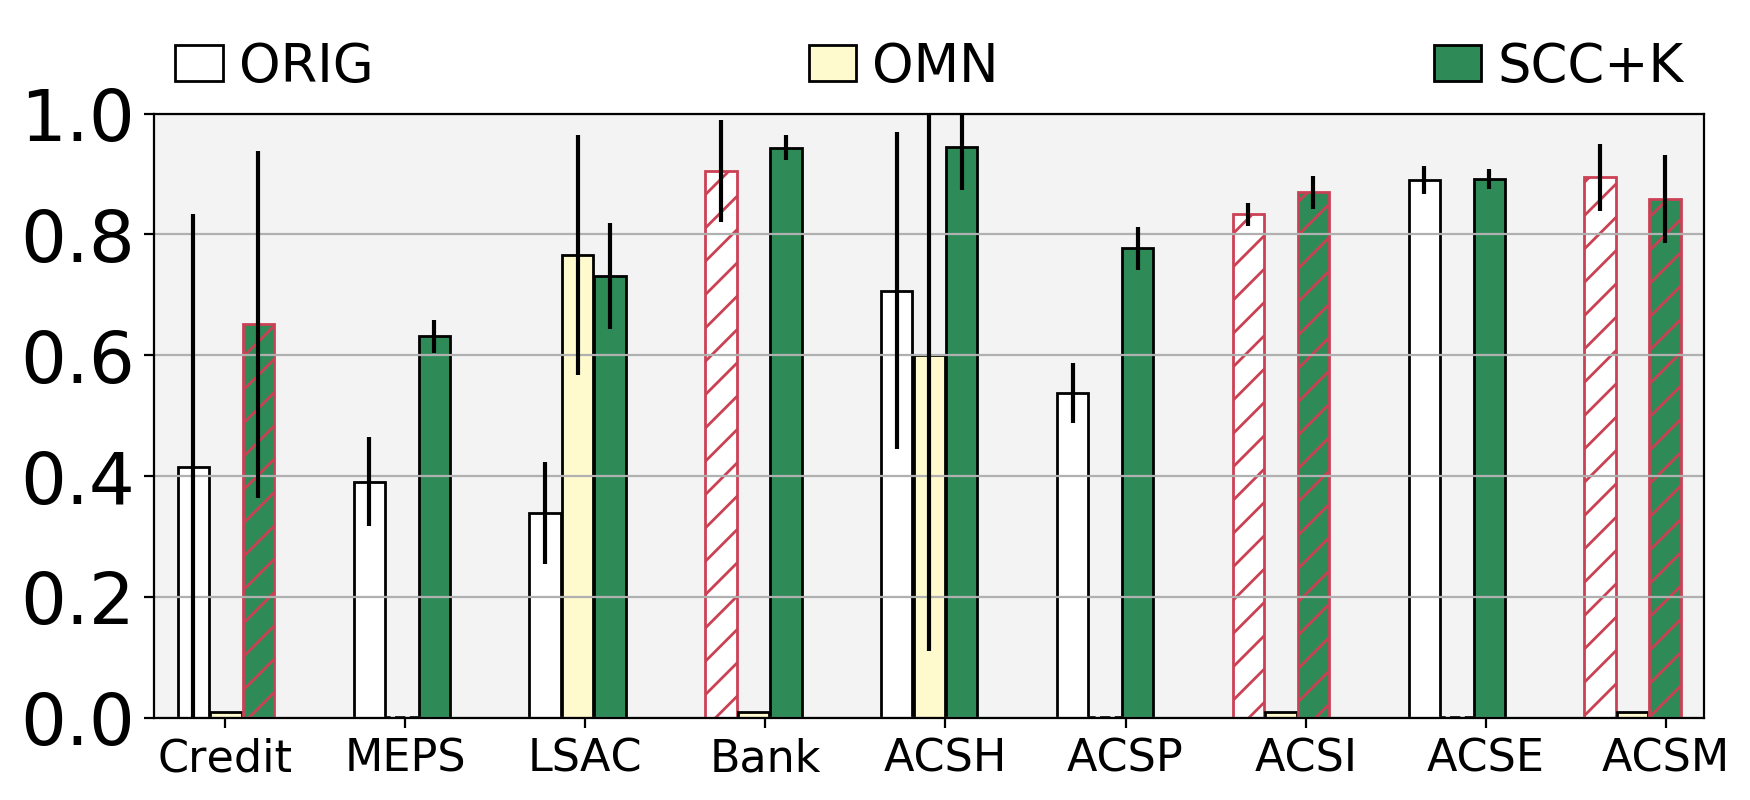

In [24]:
eval_suffix = 'aware'

exp_datasets = ['credit', 'meps16', 'lsac', 'bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']
exp_ticks = ['Credit', 'MEPS', 'LSAC', 'Bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']

# mcc_setttings = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W1', 'MCC-W2', 'SCC-KAM']
# mcc_legends = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W1', 'MCC-W2', 'SCC+K']
# mcc_colors = ['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670', '#2e8b57']

scc_settings = ['ORIG', 'OMN-ONE-AWARE', 'SCC-KAM-AWARE']
scc_legends = ['ORIG', 'OMN', 'SCC+K']
scc_colors = ['#ffffff', '#fffacd', '#2e8b57']

eval_metrics = ['BalAcc', 'DI', 'AvgOddsDiff', 'EQDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff'][1:2]

x_tick_set = 4.6
for model_name in models[1:2]:
        
    vis_df = eval_df.query('model=="{}"'.format(model_name))
    
    for exp_metric in eval_metrics:
        output_name = '{}{}-{}-{}{}-all.png'.format(plot_path, model_name, 'scc', exp_metric, eval_suffix)
        bar_plots(vis_df, output_name, exp_datasets, exp_metric, scc_settings, group_input='all', x_ticks=exp_ticks, colors=scc_colors, 
                  legend_names=scc_legends, x_tick_offset=x_tick_set,
                  legend_col=len(scc_settings),
                  save_to_disc=False)

            